<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/CNN_first_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!  pip install kaggle

In [25]:
!pip install wandb

In [4]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 90% 258M/285M [00:01<00:00, 111MB/s]
100% 285M/285M [00:05<00:00, 58.8MB/s]


In [9]:
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [10]:
# Cell 1: Import necessary libraries and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


Training data shape: (28709, 2)
Test data shape: (7178, 1)
Training data columns: ['emotion', 'pixels']

First few rows of training data:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

Emotion distribution in training data:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64


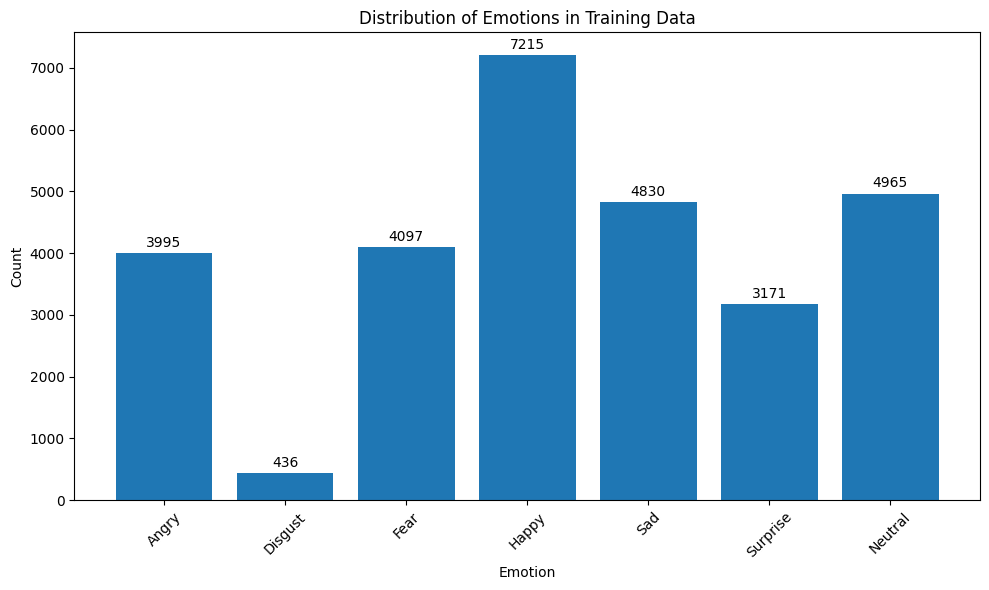

In [11]:
# Cell 2: Load and explore the data
# Load training data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Training data columns: {train_df.columns.tolist()}")

# Check first few rows
print("\nFirst few rows of training data:")
print(train_df.head())

# Check emotion distribution
print("\nEmotion distribution in training data:")
emotion_counts = train_df['emotion'].value_counts().sort_index()
print(emotion_counts)

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Visualize emotion distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in Training Data')
plt.xticks(range(7), [emotion_labels[i] for i in range(7)], rotation=45)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(emotion_counts.iloc[i]), ha='center', va='bottom')
plt.tight_layout()
plt.show()

Preprocessing training data...
Training set shape: (22967, 48, 48)
Validation set shape: (5742, 48, 48)
Training labels shape: (22967,)
Validation labels shape: (5742,)


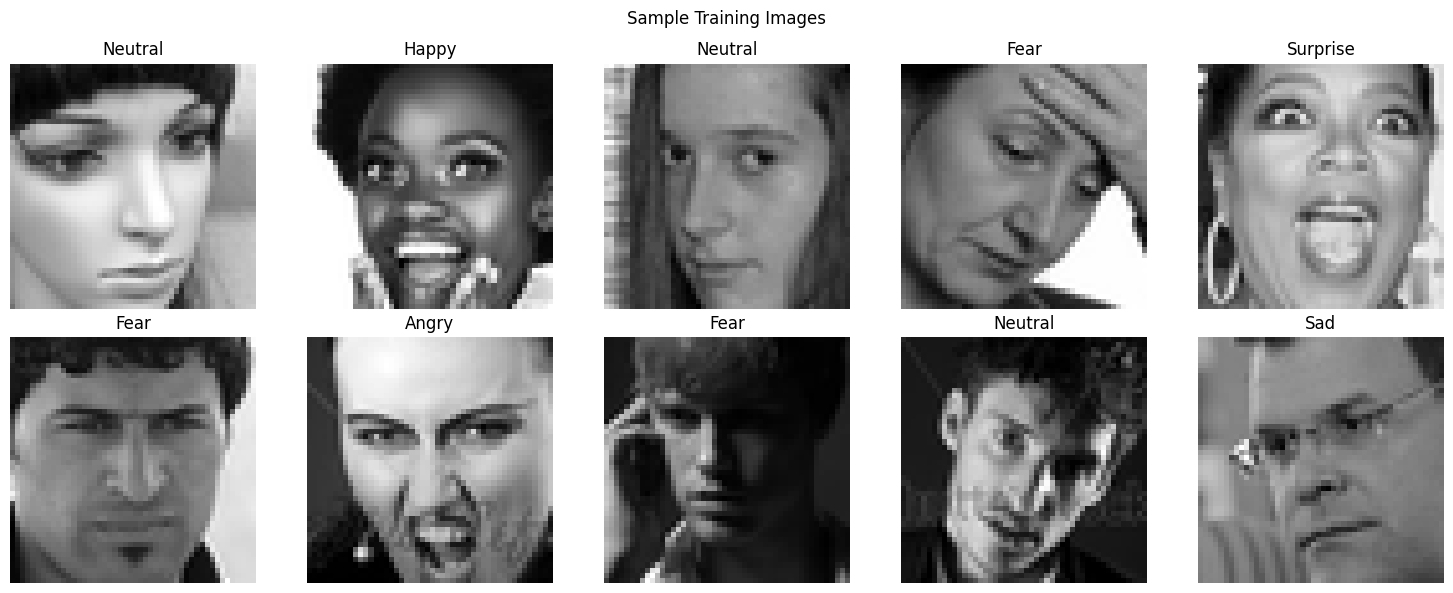

In [12]:
# Cell 3: Data preprocessing functions
def parse_pixels(pixel_string):
    """Convert pixel string to numpy array"""
    return np.array([int(pixel) for pixel in pixel_string.split()], dtype=np.float32)

def preprocess_data(df, is_train=True):
    """Preprocess the dataframe"""
    # Parse pixels
    pixels = []
    for pixel_string in df['pixels']:
        pixel_array = parse_pixels(pixel_string)
        # Reshape to 48x48 and normalize to [0, 1]
        pixel_array = pixel_array.reshape(48, 48) / 255.0
        pixels.append(pixel_array)

    pixels = np.array(pixels)

    if is_train:
        emotions = df['emotion'].values
        return pixels, emotions
    else:
        return pixels

# Preprocess training data
print("Preprocessing training data...")
X_train_full, y_train_full = preprocess_data(train_df, is_train=True)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

# Visualize some sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(X_train[i], cmap='gray')
    axes[row, col].set_title(f'{emotion_labels[y_train[i]]}')
    axes[row, col].axis('off')
plt.suptitle('Sample Training Images')
plt.tight_layout()
plt.show()

In [13]:
# Cell 4: Custom Dataset class
class FERDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Convert to PIL Image format for transforms
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image, label
        else:
            return image

# Define transforms for data augmentation (training) and normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = FERDataset(X_train, y_train, transform=train_transform)
val_dataset = FERDataset(X_val, y_val, transform=val_transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test the data loader
sample_batch = next(iter(train_loader))
print(f"Sample batch - Images shape: {sample_batch[0].shape}, Labels shape: {sample_batch[1].shape}")

Training batches: 359
Validation batches: 90
Sample batch - Images shape: torch.Size([64, 1, 48, 48]), Labels shape: torch.Size([64])


In [14]:
# Cell 5: Define CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        # Third convolutional block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third conv block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

# Initialize model
model = EmotionCNN(num_classes=7).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
# Cell 6: Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("Training setup complete!")

Training setup complete!


Starting training...

Epoch 1/25
--------------------------------------------------
Batch 0/359, Loss: 1.969180
Batch 100/359, Loss: 1.829309
Batch 200/359, Loss: 1.796595
Batch 300/359, Loss: 1.849552
Train Loss: 1.7864, Train Acc: 26.22%
Val Loss: 1.5983, Val Acc: 34.80%
New best validation accuracy: 34.80%

Epoch 2/25
--------------------------------------------------
Batch 0/359, Loss: 1.674249
Batch 100/359, Loss: 1.634060
Batch 200/359, Loss: 1.496170
Batch 300/359, Loss: 1.578838
Train Loss: 1.5879, Train Acc: 37.66%
Val Loss: 1.4650, Val Acc: 44.95%
New best validation accuracy: 44.95%

Epoch 3/25
--------------------------------------------------
Batch 0/359, Loss: 1.513927
Batch 100/359, Loss: 1.452824
Batch 200/359, Loss: 1.576413
Batch 300/359, Loss: 1.445680
Train Loss: 1.4669, Train Acc: 43.10%
Val Loss: 1.3489, Val Acc: 47.72%
New best validation accuracy: 47.72%

Epoch 4/25
--------------------------------------------------
Batch 0/359, Loss: 1.450697
Batch 100/359, Los

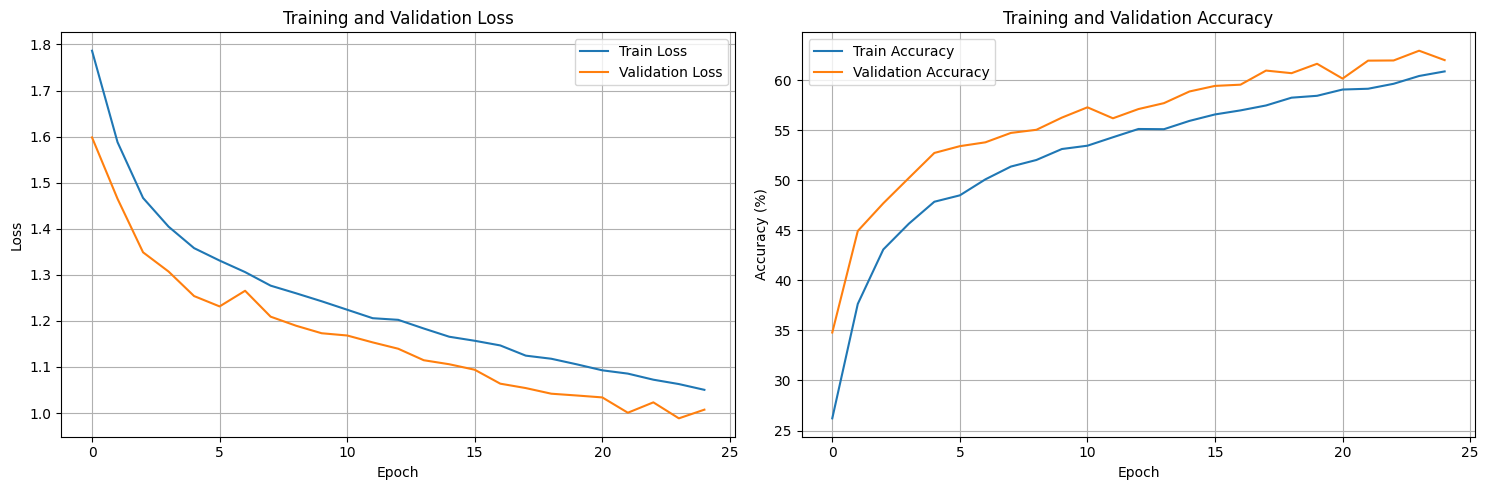

In [16]:
# Cell 7: Training loop
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f'New best validation accuracy: {best_val_acc:.2f}%')

print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')

# Load best model
model.load_state_dict(best_model_state)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Validation Accuracy: 0.6203

Classification Report:
              precision    recall  f1-score   support

       Angry       0.57      0.48      0.52       799
     Disgust       0.83      0.06      0.11        87
        Fear       0.58      0.27      0.37       820
       Happy       0.79      0.89      0.83      1443
         Sad       0.50      0.52      0.51       966
    Surprise       0.64      0.80      0.71       634
     Neutral       0.53      0.67      0.59       993

    accuracy                           0.62      5742
   macro avg       0.63      0.53      0.52      5742
weighted avg       0.62      0.62      0.60      5742



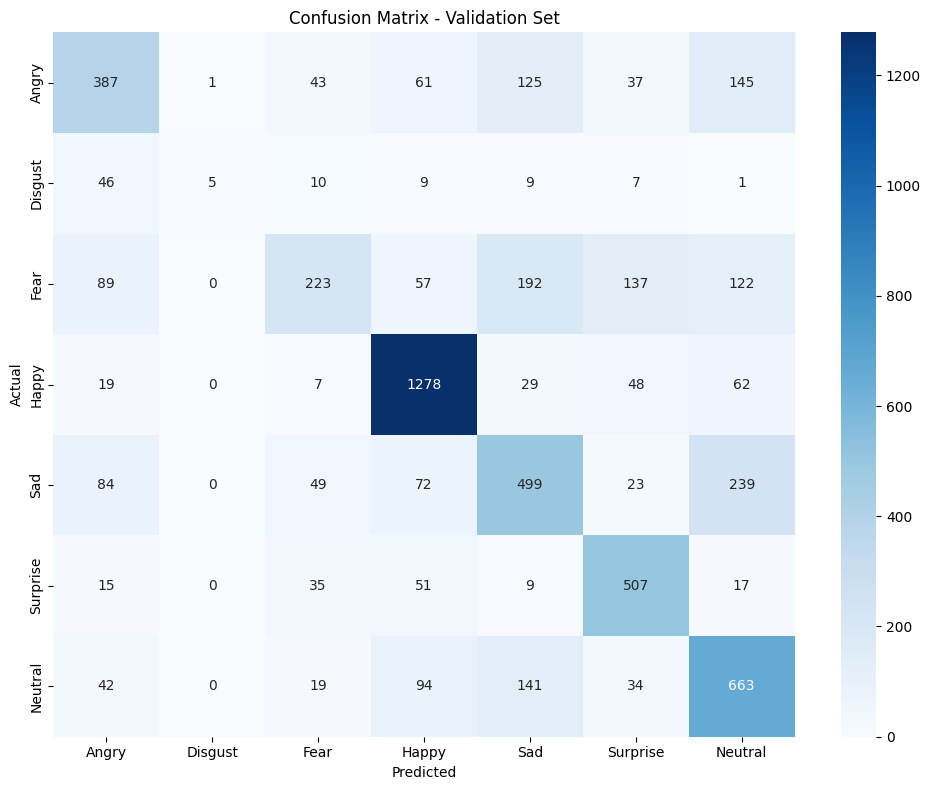

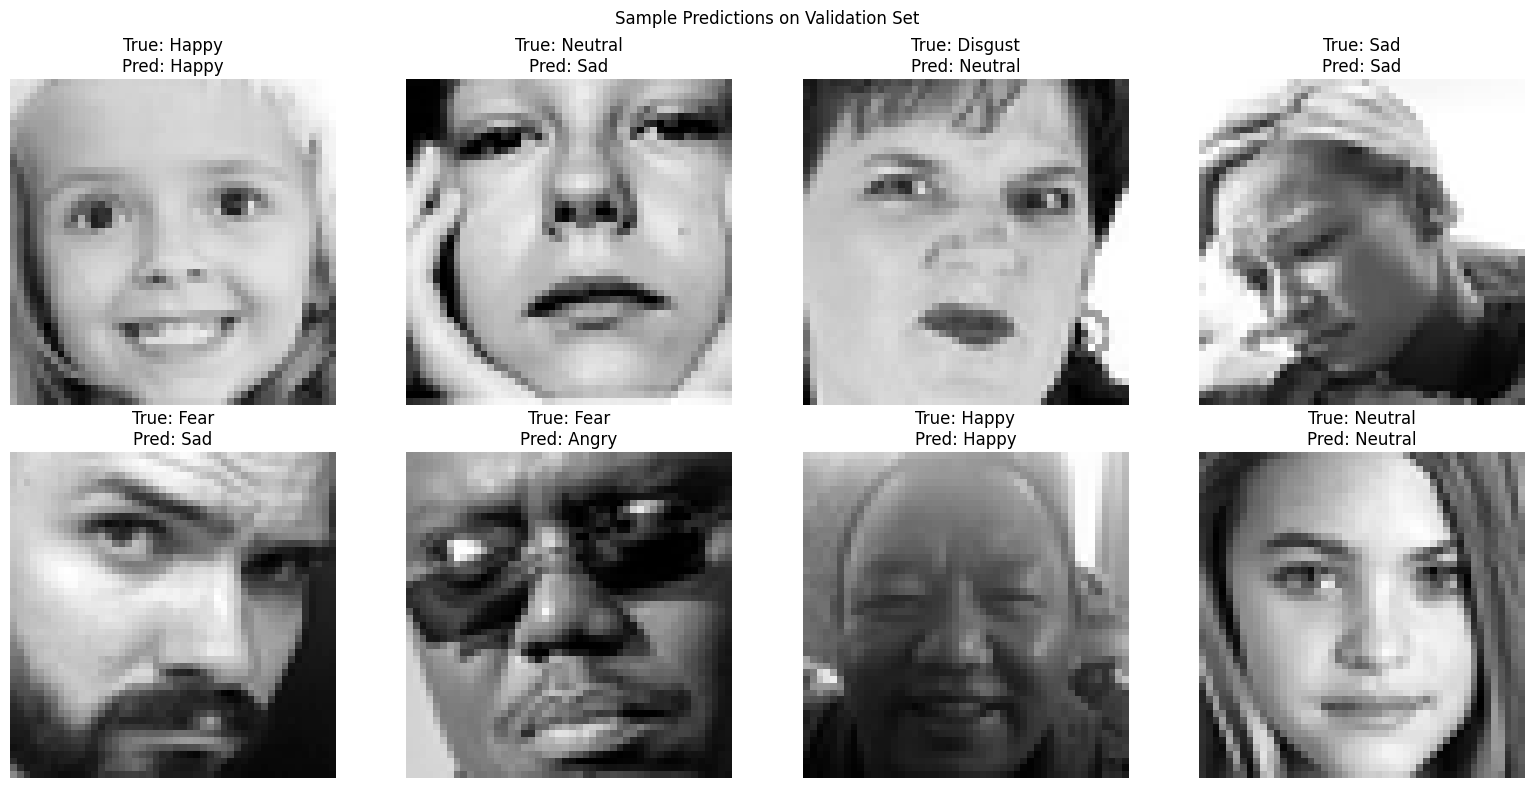

In [17]:
# Cell 8: Evaluate model on validation set
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions on validation set
val_predictions, val_true = get_predictions(model, val_loader, device)

# Calculate accuracy
val_accuracy = accuracy_score(val_true, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
class_names = [emotion_labels[i] for i in range(7)]
print(classification_report(val_true, val_predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_true, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show some validation examples with predictions
def show_predictions(model, dataset, indices, device, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices[:num_samples]):
            image, true_label = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = torch.max(output, 1)

            row = i // 4
            col = i % 4

            # Convert image back to numpy for display
            img_display = image.squeeze().cpu().numpy()
            # Denormalize
            img_display = (img_display + 1) / 2

            axes[row, col].imshow(img_display, cmap='gray')
            axes[row, col].set_title(f'True: {emotion_labels[true_label.item()]}\n'
                                   f'Pred: {emotion_labels[predicted.item()]}')
            axes[row, col].axis('off')

    plt.suptitle('Sample Predictions on Validation Set')
    plt.tight_layout()
    plt.show()

# Show some validation predictions
sample_indices = np.random.choice(len(val_dataset), 8, replace=False)
show_predictions(model, val_dataset, sample_indices, device)

In [18]:
import wandb

# Start a new wandb run to track this model
run = wandb.init(
    # Set your wandb entity (replace with your username)
    entity="zeliz22-free-university-of-tbilisi-",
    # Set the wandb project
    project="Facial Expression Recognition Challenge",
    name="CNN-FER-Model-v1",
    # Add tags to organize runs
    tags=["CNN", "facial-expression", "pytorch", "baseline-model"],
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.001,
        "final_learning_rate": optimizer.param_groups[0]['lr'],  # Get current LR from optimizer
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": 25,
        "batch_size": 64,
        "image_size": "48x48",
        "input_channels": 1,
        "num_classes": 7,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss",
        "weight_decay": 1e-4,
        # Model architecture
        "conv_blocks": 3,
        "conv_filters": [32, 32, 64, 64, 128, 128],
        "dense_units": [512, 256],
        "dropout_rates": [0.25, 0.25, 0.25, 0.5, 0.5],
        # Data augmentation
        "horizontal_flip": True,
        "rotation_range": 10,
        "normalization": "[-1, 1]",
        # Training settings
        "scheduler": "ReduceLROnPlateau",
        "scheduler_factor": 0.5,
        "scheduler_patience": 3,
    }
)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Log the final model results based on your training output
run.log({
    "final_train_accuracy": 60.90,  # From your results: Train Acc: 60.90%
    "final_train_loss": 1.0504,     # From your results: Train Loss: 1.0504
    "final_val_accuracy": 62.03,    # From your results: Val Acc: 62.03%
    "final_val_loss": 1.0073,       # From your results: Val Loss: 1.0073
    "best_val_accuracy": 62.97,     # From your results: Best validation accuracy: 62.97%
    "final_learning_rate": optimizer.param_groups[0]['lr'],
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),  # 359 batches as shown in your output

    # Per-class metrics from your classification report
    "Angry_precision": 0.57,
    "Angry_recall": 0.48,
    "Angry_f1_score": 0.52,
    "Angry_support": 799,

    "Disgust_precision": 0.83,
    "Disgust_recall": 0.06,
    "Disgust_f1_score": 0.11,
    "Disgust_support": 87,

    "Fear_precision": 0.58,
    "Fear_recall": 0.27,
    "Fear_f1_score": 0.37,
    "Fear_support": 820,

    "Happy_precision": 0.79,
    "Happy_recall": 0.89,
    "Happy_f1_score": 0.83,
    "Happy_support": 1443,

    "Sad_precision": 0.50,
    "Sad_recall": 0.52,
    "Sad_f1_score": 0.51,
    "Sad_support": 966,

    "Surprise_precision": 0.64,
    "Surprise_recall": 0.80,
    "Surprise_f1_score": 0.71,
    "Surprise_support": 634,

    "Neutral_precision": 0.53,
    "Neutral_recall": 0.67,
    "Neutral_f1_score": 0.59,
    "Neutral_support": 993,

    # Overall metrics
    "macro_avg_precision": 0.63,
    "macro_avg_recall": 0.53,
    "macro_avg_f1": 0.52,
    "weighted_avg_precision": 0.62,
    "weighted_avg_recall": 0.62,
    "weighted_avg_f1": 0.60,
    "overall_accuracy": 0.62,
    "total_validation_samples": 5742
})

# Finish the run
run.finish()

print("Model results logged to WandB successfully!")

wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Angry_f1_score,▁
Angry_precision,▁
Angry_recall,▁
Angry_support,▁
Disgust_f1_score,▁
Disgust_precision,▁
Disgust_recall,▁
Disgust_support,▁
Fear_f1_score,▁
Fear_precision,▁
Fear_recall,▁


Model results logged to WandB successfully!
